# Wikipedia Thanker Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias)
April 29, 2019

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanker study.

In [2]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(corrplot)
library(DeclareDesign)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.12.0 estimatr_0.14        fabricatr_0.6.0     
 [4] randomizr_0.16.1     corrplot_0.84        blockrand_1.3       
 [7] blockTools_0.6-3     viridis_0.5.1        viridisLite_0.3.0   
[10] forcats_0.3.0        stringr_1.3.1        dplyr_0.7.8         
[13] purrr_0.2.5          rea

# Load Input Dataframe

In [3]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/"
filename = paste("fa", "-merged-20190729.csv", sep="")
initial.thanker.df <- read.csv(file.path(data.path, "historical_survey_merged", filename))
initial.thanker.df$google_doc <- NULL
initial.thanker.df$Qualtrics <- NULL
initial.thanker.df$Google_form <- NULL

languages = c("de", "pl", "ar")
files = list()
for(lang in languages){
    filename = paste(lang, "-merged-20190729.csv", sep="")
#    print(filename)
    t.df <- read.csv(file.path(data.path, "historical_survey_merged", filename))
    initial.thanker.df <- rbind(initial.thanker.df, t.df)
}

Warning message in `[<-.factor`(`*tmp*`, ri, value = c(169, 213, 134, 103, 97, 323, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(70, 81, 107, 410, 115, 115, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(301, 120, 149, 191, 80, 150, :
“invalid factor level, NA generated”

In [4]:
nrow(initial.thanker.df)

[1] 447

### Set up Account Age Variable

In [5]:
initial.thanker.df$user_created <- as.Date(substring(initial.thanker.df$user_registration,1,10))

initial.thanker.df$account.age <- round(as.integer(max(initial.thanker.df$user_created) - initial.thanker.df$user_created) / 365)

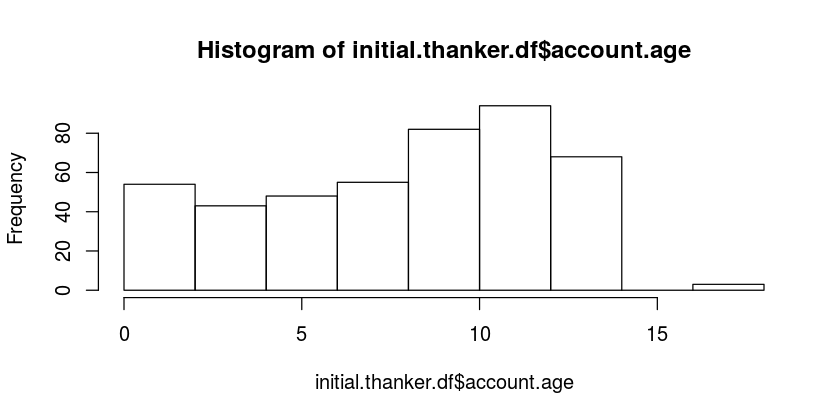

In [6]:
hist(initial.thanker.df$account.age)

# Load List of Eligible Thankers

This list is generated by the jupyter notebook script `"Calculate Per-Language Counts of Thankers and Superthankers and Generate List of Thankers.py"`

In [7]:
all.thankers.df <- read.csv(file.path(data.path,"thanker_email_recruitment/thanker_recruitment_emails-07.29.2019.csv"))

In [8]:
print(paste(nrow(all.thankers.df), "total eligible thankers"))
print(paste(nrow(initial.thanker.df), "thankers in the full dataset"))


print(paste(nrow(subset(
                initial.thanker.df, anonymized_id %in% all.thankers.df$anon_id
            )), "thankers in full dataset, constrained by eligible thankers"))

[1] "438 total eligible thankers"
[1] "447 thankers in the full dataset"
[1] "438 thankers in full dataset, constrained by eligible thankers"


# Include Only Eligible Thankers in the Randomizations

In [9]:
thanker.df <- subset(initial.thanker.df, anonymized_id %in% all.thankers.df$anon_id)
nrow(thanker.df)

[1] 438

### Create Supportive Variable

In [10]:
thanker.df$supportive_84_pre_treatment <- rowSums(thanker.df[,
                                                  c("support_talk_84_pre_treatment",
                                                    "wikithank_84_pre_treatment",
                                                    "project_talk_84_pre_treatment")], na.rm=TRUE)
print("Checking the presence of bots")
summary(thanker.df$is_official_bot)
thanker.df$is_official_bot <- as.integer(thanker.df$is_official_bot) == "True"
summary(thanker.df$is_official_bot)

[1] "Checking the presence of bots"


False 
  438

   Mode   FALSE 
logical     438 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


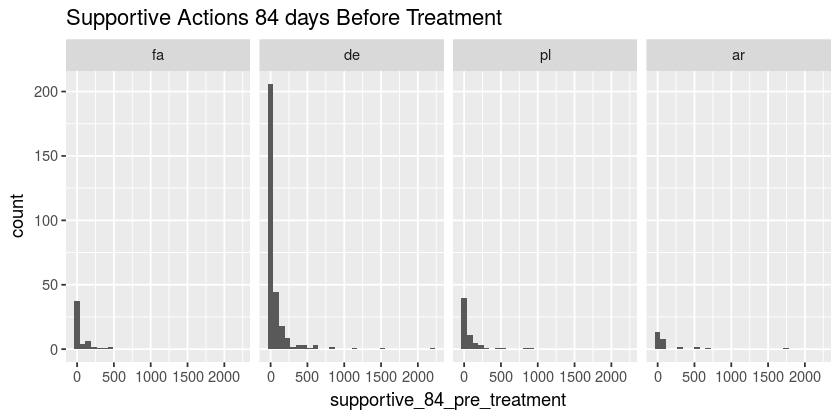

In [11]:
ggplot(thanker.df, aes(supportive_84_pre_treatment)) +
    geom_histogram() +
    facet_grid(. ~ lang ) +
    ggtitle("Supportive Actions 84 days Before Treatment")

### Self-Reported Positive Feelings about Wikipedia

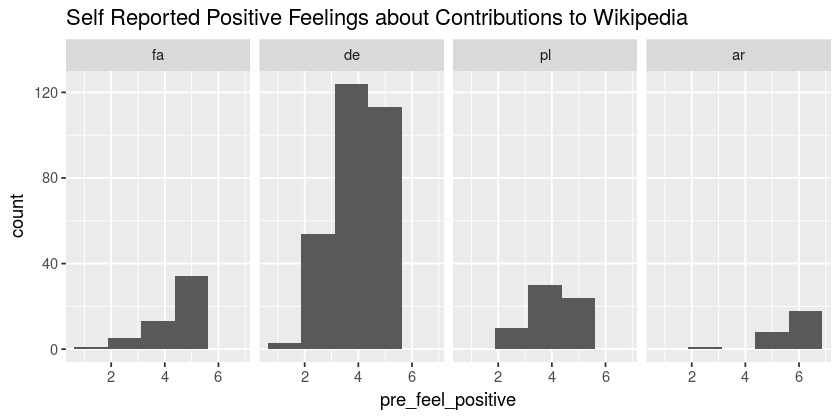

In [12]:
ggplot(thanker.df, aes(pre_feel_positive)) +
    geom_histogram(bins=5) +
    facet_grid(. ~ lang ) +
    ggtitle("Self Reported Positive Feelings about Contributions to Wikipedia")

# Trim Randomizations

### Remove Arabic Participants For Inclusion Later

In [14]:
print(paste(nrow(thanker.df), "accounts in the thanker df"))
thanker.df.not.randomized <- subset(thanker.df, lang=="ar")
print(paste("  ", nrow(thanker.df.not.randomized), "accounts removed"))
thanker.df <- subset(thanker.df, lang!="ar")
print(paste("  ", nrow(thanker.df), "accounts in the thanker df after removing AR accounts"))

[1] "438 accounts in the thanker df"
[1] "   27 accounts removed"
[1] "   411 accounts in the thanker df after removing AR accounts"


### Remove bots and subset values outside the 99% confidence intervals

Decision July 27, 2019: JNM decided not to remove outliers, since it would have too much of an impact on  

In [15]:
print(paste("Removing", nrow(subset(thanker.df, is_official_bot==TRUE)), "officially registered bots"))
thanker.df.final <- subset(thanker.df, is_official_bot != TRUE)

## CALCULATE MEANS AND SDs before making any removals
df.support.mean <- mean(thanker.df$supportive_84_pre_treatment)
df.support.sd   <- sd(thanker.df$supportive_84_pre_treatment)
df.protect.mean <- mean(thanker.df$protective_84_pre_treatment)
df.protect.sd   <- sd(thanker.df$protective_84_pre_treatment)


print(paste("Removing", 
            nrow(subset(thanker.df, 
                        supportive_84_pre_treatment > df.support.mean + 2.58* df.support.sd)),
           "observations from the study and directing them to experience the treatment condition because their value for supportive_84_pre_treatment is above the 99% confidence interval."))

thanker.df.not.randomized <- rbind(thanker.df.not.randomized, 
                                   subset(thanker.df.final, supportive_84_pre_treatment > df.support.mean + 2.58* df.support.sd))
print("Accounts Removed from Assignment per language:")
summary(thanker.df.not.randomized$lang)

thanker.df.final <- subset(thanker.df.final, supportive_84_pre_treatment <= df.support.mean + 2.58* df.support.sd)

print(paste(nrow(thanker.df.final), "total accounts included in randomizations"))
summary(thanker.df.final$lang)

print("^ In Persian and German, where there are odd numbers of participants, the matching algorithm will identify which observation matches least well, and we will remove that participant from the study and ensure they receive the treatment.")

[1] "Removing 0 officially registered bots"


Warning message in mean.default(thanker.df$protective_84_pre_treatment):
“argument is not numeric or logical: returning NA”

[1] "Removing 10 observations from the study and directing them to experience the treatment condition because their value for supportive_84_pre_treatment is above the 99% confidence interval."
[1] "Accounts Removed from Assignment per language:"


fa de pl ar 
 0  8  2 27

[1] "401 total accounts included in randomizations"


fa  de  pl  ar 
 53 286  62   0

[1] "^ In Persian and German, where there are odd numbers of participants, the matching algorithm will identify which observation matches least well, and we will remove that participant from the study and ensure they receive the treatment."


# Generate Randomization Blocks

In [17]:
## BLOCKING VARIABLES
bv = c("supportive_84_pre_treatment","account.age", "pre_feel_positive")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=thanker.df.final,
            n.tr = block.size,
            groups = "lang",
            id.vars="anonymized_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
#print(blockobj)
thanker.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=thanker.df.final,
                                   id.var = "anonymized_id")
thanker.df.final$randomization_block_size = block.size

### Identify Blocks with fewer than two participants and add them to thanker.df.not.randomized

In [18]:
block.sizes <- aggregate(thanker.df.final$randomization_block_id, FUN=length, by=list(thanker.df.final$randomization_block_id))
incomplete.blocks <- subset(block.sizes, x == 1)$Group.1

print(paste(nrow(thanker.df.not.randomized), "thankers not randomized before the addition of unmatched observations"))

thanker.df.not.randomized <- rbind(thanker.df.not.randomized, subset(thanker.df.final, randomization_block_id %in% incomplete.blocks)[colnames(thanker.df.not.randomized)])
thanker.df.randomized <- subset(thanker.df.final, (randomization_block_id %in% incomplete.blocks)!=TRUE)

print(paste(nrow(thanker.df.randomized), "thankers randomized"))
print(paste(nrow(thanker.df.not.randomized), "thankers not randomized"))

[1] "37 thankers not randomized before the addition of unmatched observations"
[1] "400 thankers randomized"
[1] "38 thankers not randomized"


# Generate Randomizations

In [19]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1394221459/
set.seed(1394221459)

In [20]:
assignments <- block_ra(blocks=thanker.df.randomized$randomization_block_id, 
                        prob=0.5)
thanker.df.randomized$randomization_arm <- assignments 

### Check Balance

In [21]:
aggregate(thanker.df.randomized$randomization_arm, FUN=mean, by=list(thanker.df.randomized$lang))

Group.1,x
fa,0.5
de,0.5
pl,0.5


In [22]:
# add 'randomization_block_id' 
#     'randomization_block_size' 
#     'randomization_arm'
thanker.df.not.randomized$randomization_block_id <- -1
thanker.df.not.randomized$randomization_block_size <- -1
thanker.df.not.randomized$randomization_arm <- 1

# Output and Archive Randomizations

In [23]:
write.csv(rbind(thanker.df.not.randomized, thanker.df.randomized), 
          file.path(data.path, "randomization_output", 
                    "all-thanker-randomization-final-20190729.csv"))

### Load and analyzing randomization file

In [24]:
randomization.data.df <- read.csv(file.path(data.path, "randomization_output", 
                    "all-thanker-randomization-final-20190729.csv"))

In [25]:
print(paste(nrow(randomization.data.df), "total participants"))
print(paste(nrow(subset(randomization.data.df, randomization_block_id >0 )), "randomized participants in file, corresponding to",
            nrow(thanker.df.randomized), "participants expected to be randomized"))

[1] "438 total participants"
[1] "400 randomized participants in file, corresponding to 400 participants expected to be randomized"


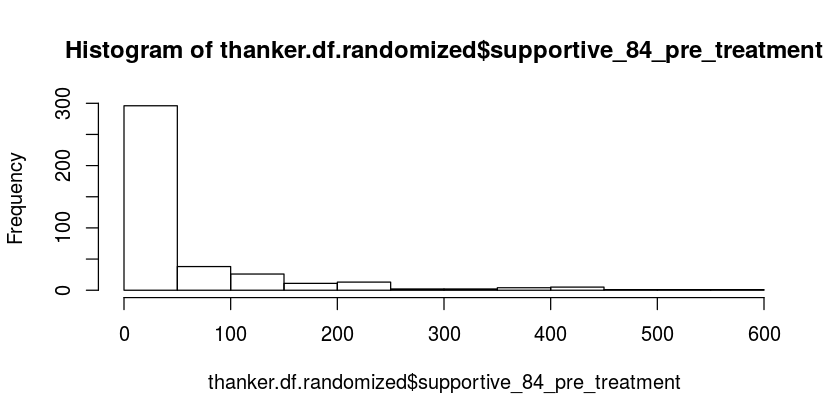

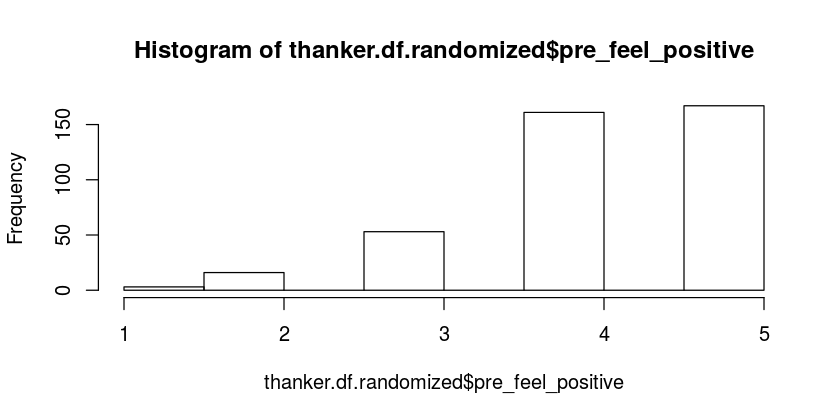

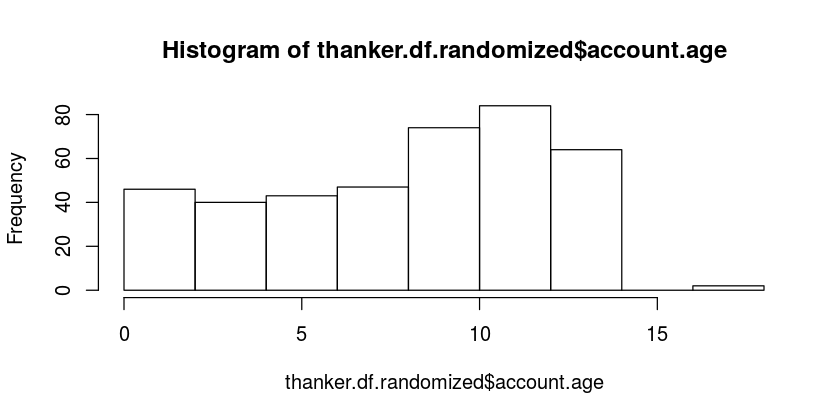

In [26]:
hist(thanker.df.randomized$supportive_84_pre_treatment)
hist(thanker.df.randomized$pre_feel_positive)
hist(thanker.df.randomized$account.age)

In [27]:
colnames(randomization.data.df)

[1] "X"                               "StartDate"                      
 [3] "EndDate"                         "Status"                         
 [5] "Progress"                        "Duration..in.seconds."          
 [7] "Finished"                        "RecordedDate"                   
 [9] "DistributionChannel"             "UserLanguage"                   
[11] "user_name"                       "anonymized_id"                  
[13] "lang"                            "user_id"                        
[15] "user_id_basic_data"              "user_registration"              
[17] "user_editcount"                  "user_experience_level"          
[19] "labor_hours_84_pre_treatment"    "total_edits_84_pre_treatment"   
[21] "num_reverts_84_pre_treatment"    "project_talk_84_pre_treatment"  
[23] "support_talk_84_pre_treatment"   "is_official_bot"                
[25] "wikithank_84_pre_treatment"      "wikilove_84_pre_treatment"      
[27] "block_actions_84_pre_treatment"  "has_email"                      
[29] "StartDate__survey"               "EndDate__survey"                
[31] "Status__survey"                  "Progress__survey"               
[33] "Duration..in.seconds.__survey"   "Finished__survey"               
[35] "RecordedDate__survey"            "ResponseId__survey"             
[37] "DistributionChannel__survey"     "UserLanguage__survey"           
[39] "overall_exp"                     "activities_1"                   
[41] "activities_2"                    "pre_monitoring_damaging_content"
[43] "pre_mentoring"                   "activities_5"                   
[45] "pre_newcomer_capability"         "trust_2"                        
[47] "pre_newcomer_intent"             "trust_4"                        
[49] "pre_emotionally_draining"        "pre_feel_positive"              
[51] "lang__survey"                    "user_created"                   
[53] "account.age"                     "supportive_84_pre_treatment"    
[55] "randomization_block_id"          "randomization_block_size"       
[57] "randomization_arm"